In [ ]:
import random
import time
from time import sleep
import matplotlib.pyplot as plt
from IPython import display
from gym_minigrid.wrappers import *
from matplotlib.offsetbox import AnnotationBbox, OffsetImage
%matplotlib inline


Create and reset the environment.

In [ ]:
class GridWold:

    def __init__(self, n, init_pos = (0, 0), target_pos = None):
        self.n = n
        self.init_pos = init_pos
        self.pos = init_pos
        if target_pos is None:
            self.target_pos = (n - 1, n - 1)
        else:
            self.target_pos = target_pos

    def reset(self, pos=None):
        if pos is None:
            self.pos = self.init_pos
        else:
            self.pos = pos
        return self.pos

    def get_available_actions(self):
        if self.pos == self.target_pos:
            res = {}
        else:
            res = {'up', 'down', 'right', 'left'}
            if self.pos[0] == 0:
                res.discard('left')
            if self.pos[0] == self.n - 1:
                res.discard('right')
            if self.pos[1] == 0:
                res.discard('up')
            if self.pos[1] == self.n - 1:
                res.discard('down')

        return res

    def step(self, action:str):
        if action == 'left':
            self.pos = (self.pos[0] - 1, self.pos[1])
        elif action == 'right':
            self.pos = (self.pos[0] + 1, self.pos[1])
        elif action == 'down':
            self.pos = (self.pos[0] , self.pos[1] + 1)
        elif action == 'up':
            self.pos = (self.pos[0], self.pos[1] - 1)

        if self.pos == self.target_pos:
            return self.pos, 100
        else:
            return self.pos, 0

    def render(self):
        n = self.n
        agent = OffsetImage(plt.imread('imgs/agent.png'), zoom=1/(2*n))
        target = OffsetImage(plt.imread('imgs/target.png'), zoom=10/(2*n))

        fig = plt.figure(figsize=(10, 10))
        ax = fig.add_subplot(1, 1, 1)
        for j in range(n + 1):
            ax.axvline(x = j/n)
            ax.axhline(y = j/n)

        ab_target = AnnotationBbox(target, xy = ((self.target_pos[0]+0.5)/n, 1 - (self.target_pos[1]+0.7)/n), frameon=False)
        ax.add_artist(ab_target)

        ab_agent = AnnotationBbox(agent, xy = ((self.pos[0] + 0.5)/n, 1 - (self.pos[1]+0.5)/n), frameon=False)
        ax.add_artist(ab_agent)
        plt.show()



We now navigate this grid world randomly.

In [ ]:
env = GridWold(5)
e = 0
for n in range(1000):
    time.sleep(0.1)
    display.clear_output(wait=True)
    available_actions = env.get_available_actions()
    if not available_actions:
        env.reset()
        e += 1
        continue
    action = random.sample(available_actions, 1)[0]
    pos, reward = env.step(action)
    env.render()
    print(f'Iteration: {n} of Episodes {e}')
    print(f'Available actions: {available_actions}')
    print(f'Action taken: {action}')
    print(f'Reward: {reward}')
    print(f'Position: {pos}')

In [189]:
def key_with_max_value(d):
    max_value = max(d.values())
    max_keys = []
    for key, value in d.items():
        if value == max_value:
            max_keys.append(key)
    return random.sample(max_keys, 1)[0]

l = 0.9
q_table = {}

size = 5
env = GridWold(size)
pos = env.reset()

env.render()
time.sleep(0.1)
display.clear_output(wait=True)

e = 0
for n in range(10000):
    available_actions = env.get_available_actions()
    if not available_actions:
        if e % 10 == 0:
            env.render()
            time.sleep(0.1)
            display.clear_output(wait=True)
        e += 1
        if e % 10 == 0:
            pos = env.reset()
            env.render()
            time.sleep(0.1)
            display.clear_output(wait=True)
        else:
            init_pos = None #(random.randint(0, size - 1), random.randint(0, size - 1))
            pos = env.reset(init_pos)
        continue

    if pos in q_table:
        action_probs = q_table[pos]
    else:
        action_probs = {a : 0 for a in available_actions}
        q_table[pos] = action_probs

    action = key_with_max_value(action_probs)

    pos, reward = env.step(action)

    if pos in q_table:
        action_probs[action] = reward + l * max(q_table[pos].values())
    else:
        action_probs[action] = reward

    if e % 10 == 0:
        env.render()
        print(f'Iteration: {n} of Episode {e}')
        print(f'Available actions: {available_actions}')
        print(f'Action taken: {action}')
        print(f'Reward: {reward}')
        print(f'Position: {pos}')
        for key in q_table:
            print(key, q_table[key])
        time.sleep(0.1)
        display.clear_output(wait=True)


KeyboardInterrupt: 

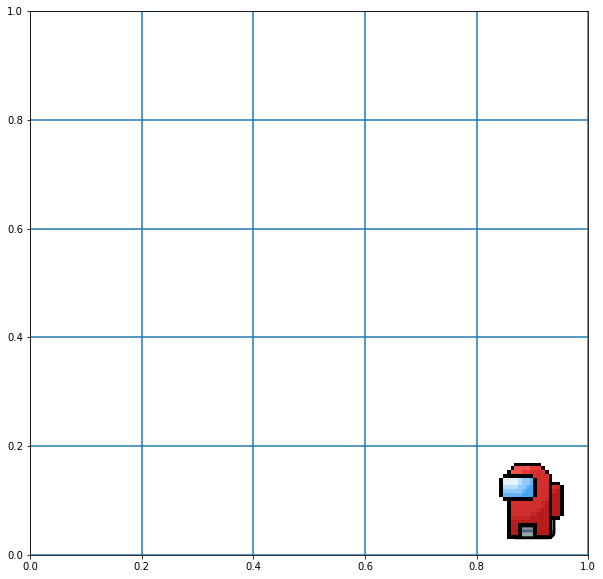

In [174]:
pos = env.reset()

for n in range(1000):
    time.sleep(0.1)
    display.clear_output(wait=True)

    available_actions = env.get_available_actions()
    if not available_actions:
        env.render()
        break

    if pos in q_table:
        action_probs = q_table[pos]
    else:
        action_probs = {a : 0 for a in available_actions}
        q_table[pos] = action_probs

    action = key_with_max_value(action_probs)

    pos, reward = env.step(action)

    env.render()
    print(f'Iteration: {n} of Episodes {e}')
    print(f'Available actions: {available_actions}')
    print(f'Action taken: {action}')
    print(f'Reward: {reward}')
    print(f'Position: {pos}')

In [ ]:
env = gym.make('MiniGrid-Empty-16x16-v0')


This is how the environment looks like at the beginning. We have a grid world with an agent in the top left corner
that can navigate this empty room. On the bottom right corner we have the target location.

In [ ]:
plt.figure(figsize=(9, 9))
plt.imshow(env.render(mode='rgb_array'))

This environment supports the following actions.

In [20]:
for action in list(env.actions):
    print(action)



Actions.left
Actions.right
Actions.forward
Actions.pickup
Actions.drop
Actions.toggle
Actions.done


In [ ]:
for _ in range(100):
    img.set_data(env.render(mode='rgb_array'))
    display.display(plt.gcf())
    display.clear_output(wait=True)
    action = env.action_space.sample()
    print(env.step(action))
env.close()

6


({'image': array([[[2, 5, 0],
          [2, 5, 0],
          [2, 5, 0],
          [2, 5, 0],
          [2, 5, 0],
          [2, 5, 0],
          [2, 5, 0]],
  
         [[2, 5, 0],
          [2, 5, 0],
          [2, 5, 0],
          [2, 5, 0],
          [2, 5, 0],
          [2, 5, 0],
          [2, 5, 0]],
  
         [[2, 5, 0],
          [2, 5, 0],
          [2, 5, 0],
          [2, 5, 0],
          [2, 5, 0],
          [2, 5, 0],
          [2, 5, 0]],
  
         [[2, 5, 0],
          [2, 5, 0],
          [2, 5, 0],
          [2, 5, 0],
          [2, 5, 0],
          [2, 5, 0],
          [1, 0, 0]],
  
         [[2, 5, 0],
          [2, 5, 0],
          [2, 5, 0],
          [2, 5, 0],
          [2, 5, 0],
          [2, 5, 0],
          [1, 0, 0]],
  
         [[2, 5, 0],
          [2, 5, 0],
          [2, 5, 0],
          [2, 5, 0],
          [2, 5, 0],
          [2, 5, 0],
          [1, 0, 0]],
  
         [[2, 5, 0],
          [2, 5, 0],
          [2, 5, 0],
          [2, 5, 0],
 

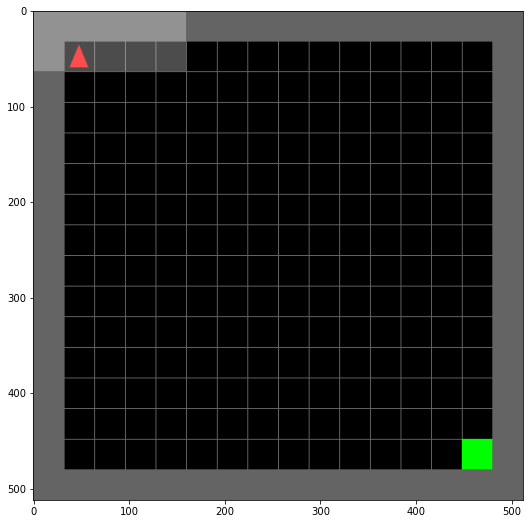

In [15]:
plt.figure(figsize=(9, 9))
img = plt.imshow(env.render(mode='rgb_array'))
img.set_data(env.render(mode='rgb_array'))
display.display(plt.gcf())
display.clear_output(wait=True)

action = env.action_space.sample()
print(action)
env.step(action)

[<Actions.left: 0>, <Actions.right: 1>, <Actions.forward: 2>, <Actions.pickup: 3>, <Actions.drop: 4>, <Actions.toggle: 5>, <Actions.done: 6>]
